In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/KalmanNet_Visual/KalmanNet_VO/KNet_original_code

/content/drive/MyDrive/KalmanNet_Visual/KalmanNet_VO/KNet_original_code


In [ ]:
import torch
from KalmanNet_sysmdl import SystemModel
from Pipeline_EKF_original_mod import Pipeline_EKF
from KalmanNet_nn import KalmanNetNN
from model import f, h_full, h_partial, h_nonlinear
import datetime
from datetime import date
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available():
   dev = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
   torch.set_default_tensor_type('torch.cuda.FloatTensor')
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

ROOT_PATH = "/content/drive/MyDrive/KalmanNet_Visual/KalmanNet_VO/"



Running on the CPU
using CPU!
Running on the CPU
Running on the CPU


In [ ]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


Evaluation for r2 10, q2 1.0 

Beginning with q2 1.0, r2 10.
Current Time = 06.15.22_15:59:29
WARM UP PHASE
ACTUAL TRAINING PHASE
0, MSE Training total/theta/omega: 1.00/1.00/3.70 [dB], MSE Validation total/theta/omega :0.53/0.53/8.58 [dB]
Optimal idx: 0 Optimal : tensor(0.5332) [dB]
1, MSE Training total/theta/omega: 0.79/0.79/3.72 [dB], MSE Validation total/theta/omega :0.45/0.45/8.54 [dB]
Optimal idx: 1 Optimal : tensor(0.4479) [dB]
2, MSE Training total/theta/omega: 0.78/0.78/3.75 [dB], MSE Validation total/theta/omega :0.36/0.36/8.47 [dB]
diff MSE Training total/theta/cv : -0.01/-0.01/0.03 [dB], diff MSE Validation total/theta/cv: -0.087533/-0.087533/-0.067702 [dB]
Optimal idx: 2 Optimal : tensor(0.3604) [dB]
3, MSE Training total/theta/omega: 0.63/0.63/3.62 [dB], MSE Validation total/theta/omega :0.27/0.27/8.39 [dB]
diff MSE Training total/theta/cv : -0.15/-0.15/-0.13 [dB], diff MSE Validation total/theta/cv: -0.087368/-0.087368/-0.080527 [dB]
Optimal idx: 3 Optimal : tensor(0.27

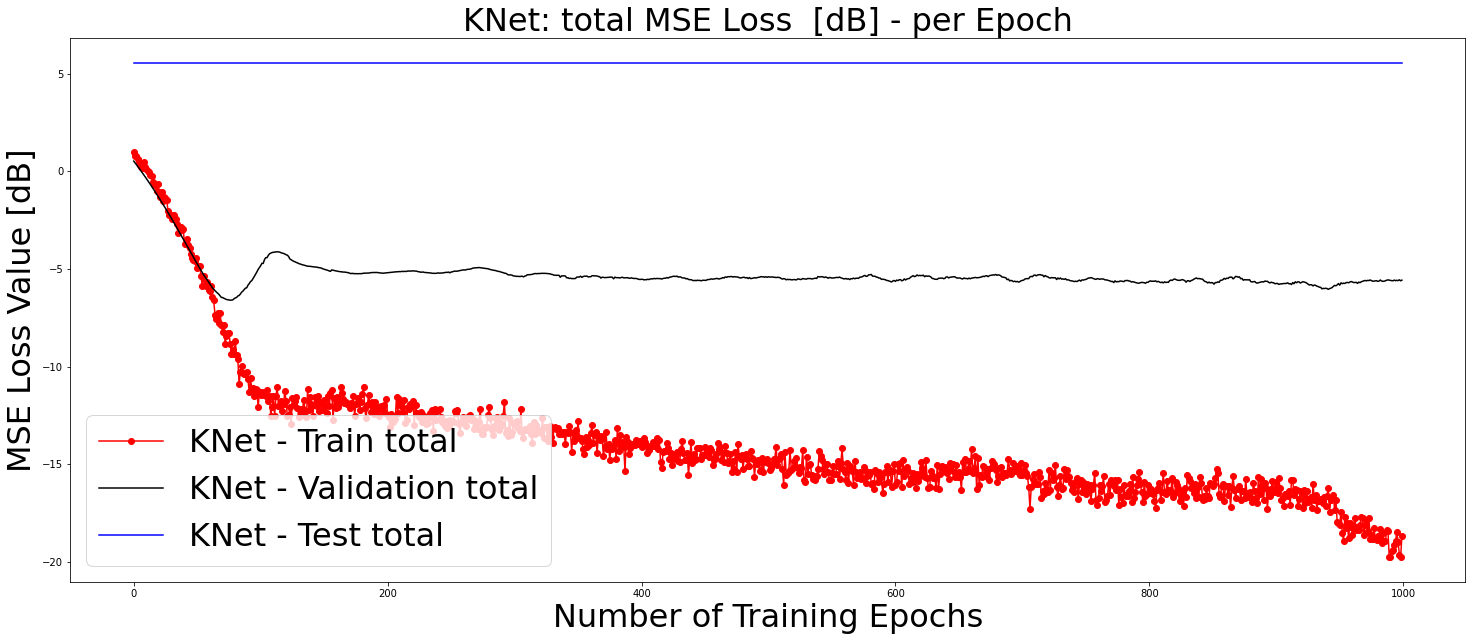

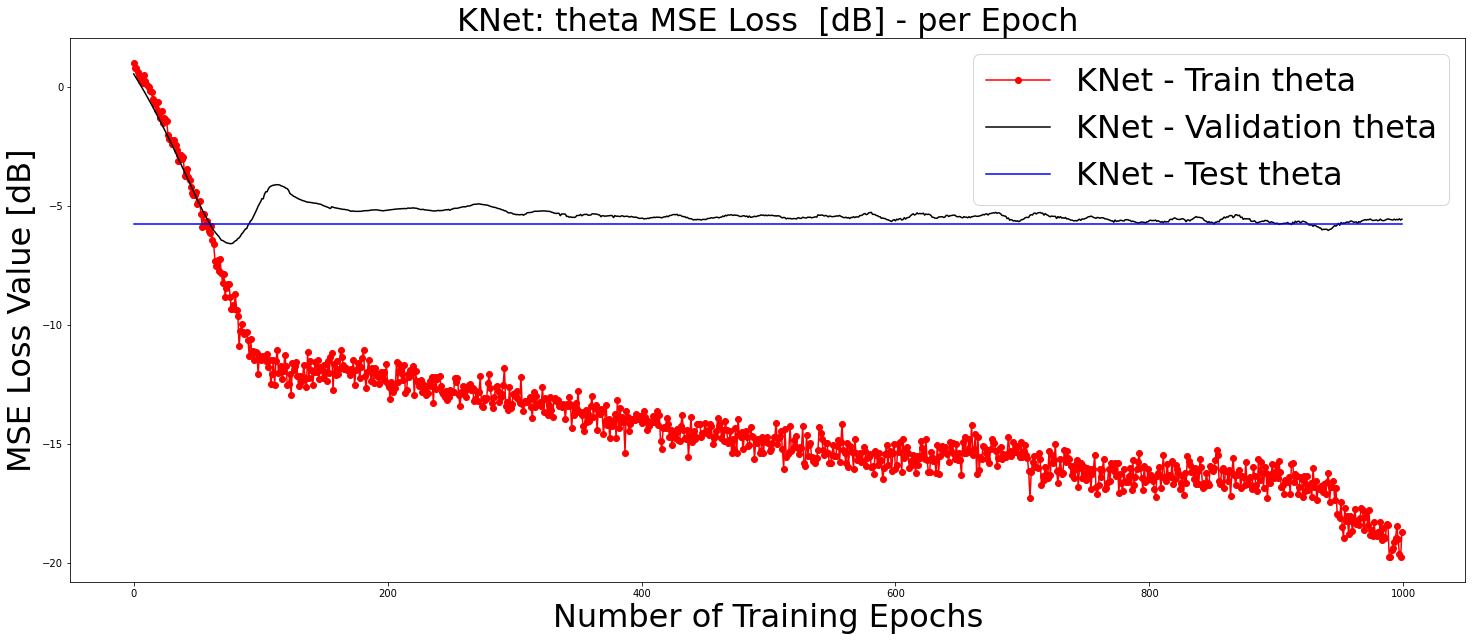

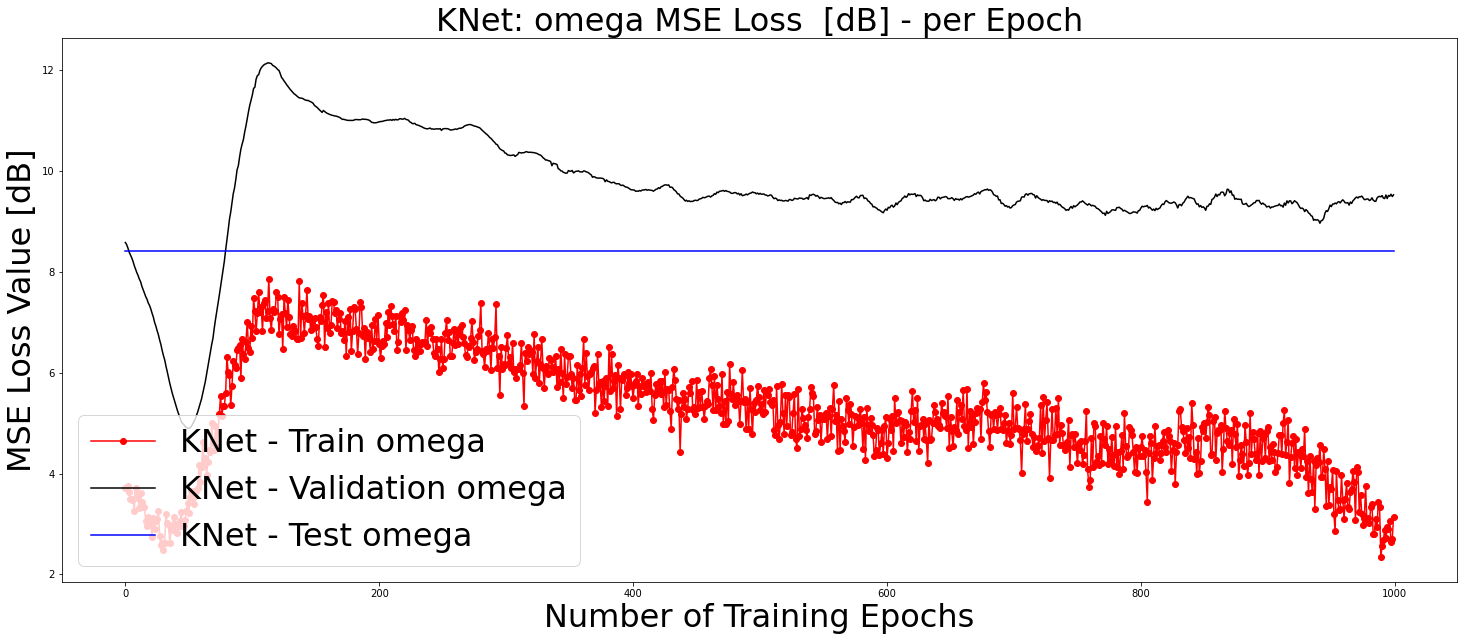

In [ ]:

###CONSTANT Q2 EXPERIMENT###
weight_theta_loss = 1
weight_omega_loss = 0 

T = 50
T_test = 400
T_cv = 400
samples_train = 3000 #size of training set
samples_cv = 10 #size of validation set
step=8


EPOCHS = 1000
BATCH_SIZE = 200


warm_up_T = 50
warm_up_T_cv = 50
BATCH_SIZE_warm = 2
EPOCHS_warm = 0


LR = 1e-4
WD = 1e-4



modelKnow = "partial"




linewidth=0.5
markersize=2
title_size=7
ax_label_size=7

m1x_0 = torch.Tensor([[0.0], [0.0]]).to(dev)
m2x_0 = torch.eye(2)


r2s = [10, 2, 1, 0.5, 0.1, 0.01, 0.001, 0.0001]
r2s = [0.5, 0.1, 0.01, 0.001, 0.0001]
r2s = [10]
q2s = [0, -10, -20]
q2s = [0]
q2s = list(map(lambda x: 10**(x/10), q2s))
v = 0

for q2 in q2s:
  input_ = np.load(ROOT_PATH+f"Datasets/Pendulum/decimated_clean_data/pendulum_decimated_q2_{q2:.0e}_v_{v}.npz")
  target_ = input_
  for r2 in r2s:
    print(f"Evaluation for r2 {r2}, q2 {q2} \n")
    
    r = np.sqrt(r2)
    q = np.sqrt(q2)

    """
    if modelKnow == "partial":
      train_input = torch.from_numpy(input_["training_set"][:samples_train, 0:1, ::step]).to(dev) + torch.randn(input_["training_set"][:samples_train, 0:1, ::step].shape) * r
      train_target = torch.from_numpy(target_["training_set"][:samples_train, :, ::step]).float().to(dev)
      cv_input = torch.from_numpy(input_["validation_set"][:samples_cv, 0:1, ::step]).to(dev) + torch.randn(input_["validation_set"][:samples_cv, 0:1, ::step].shape) * r
      cv_target = torch.from_numpy(target_["validation_set"][:samples_cv, :, ::step]).float().to(dev)
       
      train_input_warm_up = torch.from_numpy(input_["training_set"][2000:2200, 0:1, ::step]).to(dev) + torch.randn(input_["training_set"][2000:2200, 0:1, ::step].shape) * r
      train_target_warm_up = torch.from_numpy(target_["training_set"][2000:2200, :, ::step]).float().to(dev)
      cv_input_warm_up = torch.from_numpy(input_["validation_set"][500:550, 0:1, ::step]).to(dev) + torch.randn(input_["validation_set"][500:550, 0:1, ::step].shape) * r
      cv_target_warm_up = torch.from_numpy(target_["validation_set"][500:550, :, ::step]).float().to(dev)

      test_input = torch.from_numpy(input_["test_set"][:, 0:1, ::step]).to(dev) + torch.randn(input_["test_set"][:, 0:1, ::step].shape) * r
      test_target = torch.from_numpy(target_["test_set"][:, :, ::step]).float().to(dev)

      h = h_partial
      m = 2  # DIMENSION OF STATE
      n = 1
      """
    if modelKnow == "partial":
      train_input = torch.from_numpy(input_["training_set"][:samples_train, 0:1, :T]).to(dev) + torch.randn(input_["training_set"][:samples_train, 0:1, :T].shape) * r
      train_target = torch.from_numpy(target_["training_set"][:samples_train, :, :T]).float().to(dev)
      cv_input = torch.from_numpy(input_["validation_set"][:samples_cv, 0:1, :T_cv]).to(dev) + torch.randn(input_["validation_set"][:samples_cv, 0:1, :T_cv].shape) * r
      cv_target = torch.from_numpy(target_["validation_set"][:samples_cv, :, :T_cv]).float().to(dev)
      
      #train_input_warm_up = torch.from_numpy(input_["training_set"][2000:2200, 0:1, :warm_up_T]).to(dev) + torch.randn(input_["training_set"][2000:2200, 0:1, :warm_up_T].shape) * r
      #train_target_warm_up = torch.from_numpy(target_["training_set"][2000:2200, :, :warm_up_T]).float().to(dev)
      #cv_input_warm_up = torch.from_numpy(input_["validation_set"][500:550, 0:1, :warm_up_T_cv]).to(dev) + torch.randn(input_["validation_set"][500:550, 0:1, :warm_up_T_cv].shape) * r
      #cv_target_warm_up = torch.from_numpy(target_["validation_set"][500:550, :, ::warm_up_T_cv]).float().to(dev)

      test_input = torch.from_numpy(input_["test_set"][:, 0:1, :T_test]).to(dev) + torch.randn(input_["test_set"][:, 0:1, :T_test].shape) * r
      test_target = torch.from_numpy(target_["test_set"][:, :, :T_test]).float().to(dev)

      h = h_partial
      m = 2  # DIMENSION OF STATE
      n = 1

    train_input = train_input.float().to(dev)
    #cv_input = cv_input.float().to(dev)
    #train_input_warm_up = train_input_warm_up.float().to(dev)
    #cv_input_warm_up = cv_input_warm_up.float().to(dev)
    test_input = test_input.float().to(dev)
    cv_input = cv_input.float().to(dev)


  
    print(f"Beginning with q2 {q2}, r2 {r2}.")
    today = date.today()
    now = datetime.datetime.now()
    strToday = today.strftime("%m.%d.%y")
    strNow = now.strftime("%H:%M:%S")
    strTime = strToday + "_" + strNow
    print("Current Time =", strTime)


    Q_true = q2 * torch.eye(m)
    R_true = r2 * torch.eye(n)

    #WARM UP PHASE
    print("WARM UP PHASE")
    #sys_model = SystemModel(f, Q_true, h, R_true, warm_up_T, T_test, warm_up_T_cv)
    sys_model = SystemModel(f, Q_true, h, R_true, T, T_test, T_cv)

    modelFolder = ROOT_PATH +f"Simulations_results/Pendulum/KalmanNet/constant_q2_experiment/tuning_experiments/experiment_T{T}_Tcv{T_cv}_Ttest{T_test}_B{BATCH_SIZE}_LR{LR}_WD{WD}_NT{samples_train}_NCV{samples_cv}_wt_{weight_theta_loss}_wo_{weight_omega_loss}/models"
    folder = ROOT_PATH + f"Simulations_results/Pendulum/KalmanNet/constant_q2_experiment/tuning_experiments/experiment_T{T}_Tcv{T_cv}_Ttest{T_test}_B{BATCH_SIZE}_LR{LR}_WD{WD}_NT{samples_train}_NCV{samples_cv}_wt_{weight_theta_loss}_wo_{weight_omega_loss}/losses"
    os.makedirs(modelFolder+"/", exist_ok=True)
    os.makedirs(folder+"/", exist_ok=True)
    KNet_Pipeline = Pipeline_EKF(strTime, modelFolder, f"KNet")
    KNet_Pipeline.setssModel(sys_model)
    
    KNet_model = KalmanNetNN()
    KNet_model.Build(sys_model)
    KNet_Pipeline.setModel(KNet_model)
    #KNet_Pipeline.setTrainingParams(n_Epochs=EPOCHS_warm, n_Batch=BATCH_SIZE_warm, learningRate=LR, weightDecay=WD)
    #KNet_Pipeline.NNTrain(train_input_warm_up, train_target_warm_up, cv_input_warm_up, cv_target_warm_up, save_model_wrt=0)
    print("ACTUAL TRAINING PHASE")
    #TRAINING PHASE
    
    #KNet_Pipeline.setssModel(sys_model)


    KNet_Pipeline.setTrainingParams(n_Epochs=EPOCHS, n_Batch=BATCH_SIZE, learningRate=LR, weightDecay=WD)
    KNet_Pipeline.NNTrain(train_input, train_target, cv_input, cv_target, weight_theta_loss=weight_theta_loss, weight_omega_loss=weight_omega_loss, save_model_wrt=0)
    
    cv_loss = KNet_Pipeline.MSE_cv_linear_epoch.detach().cpu().numpy()
    training_loss = KNet_Pipeline.MSE_train_linear_epoch.detach().cpu().numpy()
    

    np.savez(folder + f"/training_loss.npz", training_loss=training_loss, validation_loss=cv_loss, batch_size=BATCH_SIZE, epochs=EPOCHS, learning_rate=LR, weight_decay= WD)

    
    [MSE_test_linear_arr_total, MSE_test_dB_avg_total, MSE_test_dB_std_total,
    MSE_test_linear_arr_theta, MSE_test_dB_avg_theta, MSE_test_dB_std_theta,
    MSE_test_linear_arr_omega, MSE_test_dB_avg_omega, MSE_test_dB_std_omega, x_out_array] = KNet_Pipeline.NNTest(test_input, test_target)
    KNet_Pipeline.PlotTrain_KF()
    KNet_Pipeline.save()
    
    np.savez(folder+f"/test_loss.npz", MSE_linear_arr_total=MSE_test_linear_arr_total.cpu(), 
            MSE_std_total=MSE_test_dB_std_total.cpu(), MSE_db_avg_total=MSE_test_dB_avg_total.cpu(),
            MSE_linear_arr_theta=MSE_test_linear_arr_theta.cpu(), MSE_std_theta=MSE_test_dB_std_theta.cpu(), 
            MSE_db_avg_theta=MSE_test_dB_avg_theta.cpu(), MSE_linear_arr_omega=MSE_test_linear_arr_omega.cpu(), 
            MSE_std_omega=MSE_test_dB_std_omega.cpu(), MSE_db_avg_omega=MSE_test_dB_avg_omega.cpu(), 
            test_out=x_out_array.cpu(), batch_size=BATCH_SIZE, epochs=EPOCHS, learning_rate=LR, weight_decay=WD)
    

torch.Size([10, 1, 400])
0, MSE Training total/theta/omega: 9.17/-4.62/12.09 [dB], MSE Validation total/theta/omega :21.88/23.36/19.60 [dB]
Optimal idx: 0 Optimal : tensor(21.8783) [dB]
1, MSE Training total/theta/omega: 149.81/151.69/146.41 [dB], MSE Validation total/theta/omega :155.43/157.31/152.03 [dB]
Optimal idx: 0 Optimal : tensor(21.8783) [dB]
2, MSE Training total/theta/omega: 52.16/55.03/40.04 [dB], MSE Validation total/theta/omega :54.41/57.28/42.21 [dB]
diff MSE Training total/theta/cv : -97.65/-96.66/-106.37 [dB], diff MSE Validation total/theta/cv: -101.019836/-100.025513/-109.813957 [dB]
Optimal idx: 0 Optimal : tensor(21.8783) [dB]
3, MSE Training total/theta/omega: 5.74/-7.05/8.63 [dB], MSE Validation total/theta/omega :5.92/-5.83/8.79 [dB]
diff MSE Training total/theta/cv : -46.42/-62.09/-31.41 [dB], diff MSE Validation total/theta/cv: -48.481865/-63.113815/-33.426632 [dB]
Optimal idx: 3 Optimal : tensor(5.9242) [dB]
4, MSE Training total/theta/omega: 2.80/-11.24/5.73

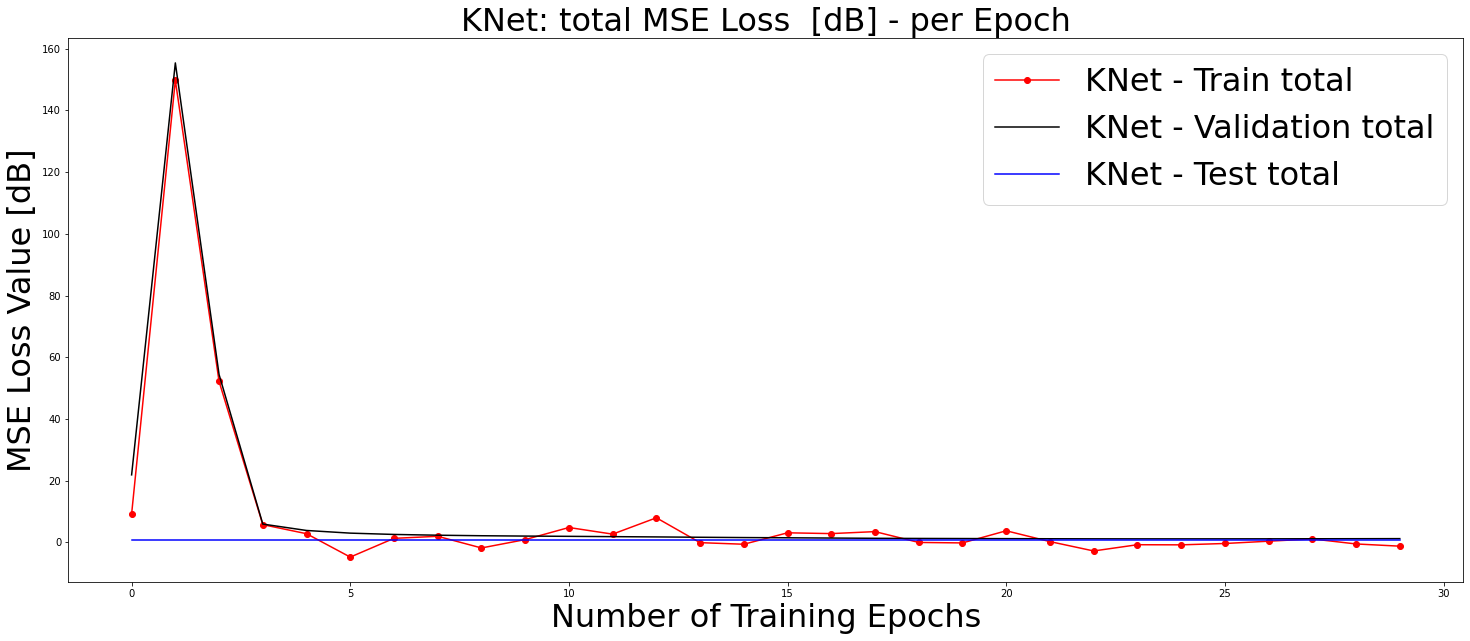

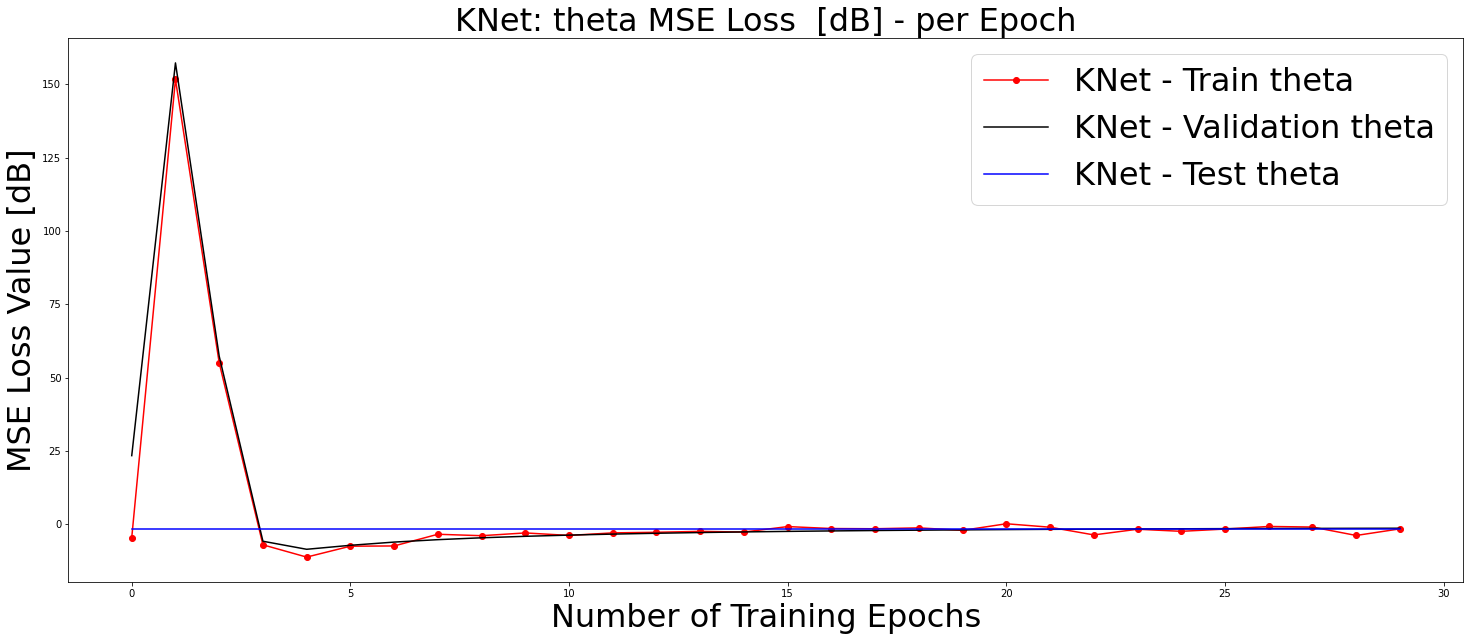

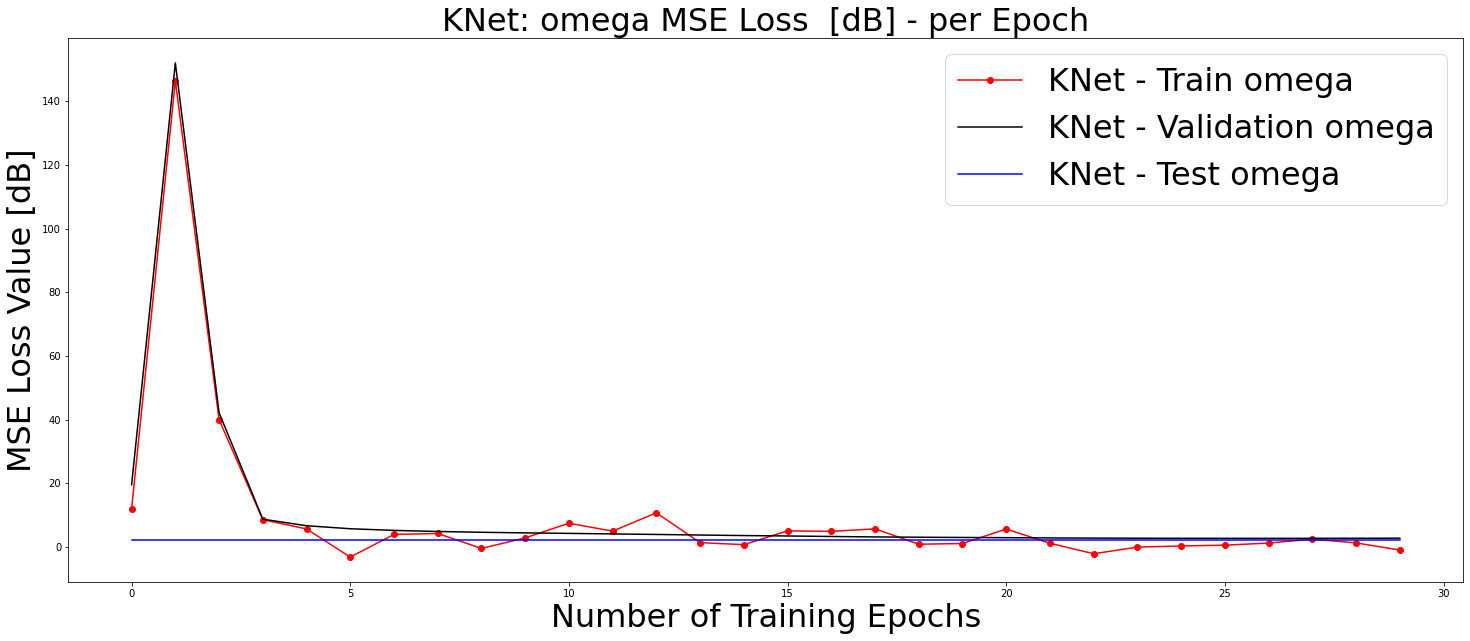

In [ ]:
 #CONTINUE TRAINING 
r2s = [10]
q2s = [0, -10, -20]
q2s = [0]
q2s = list(map(lambda x: 10**(x/10), q2s))
v = 0
T_test = 400
T = 400
T_cv = 400
samples_train = 200 #size of training set
samples_cv = 200 #size of validation set
step=8


BATCH_SIZE_warm = 2
EPOCHS_warm = 0

EPOCHS = 30
BATCH_SIZE = 1
LR = 1e-3
WD = 1e-7
r2=10
for q2 in q2s:
  input_ = np.load(ROOT_PATH+f"Datasets/Pendulum/decimated_clean_data/pendulum_decimated_q2_{q2:.0e}_v_{v}.npz")
  target_ = input_
  r = np.sqrt(r2)
  q = np.sqrt(q2)
  train_input = torch.from_numpy(input_["training_set"][:samples_train, 0:1, :T]).to(dev) + torch.randn(input_["training_set"][:samples_train, 0:1, :T].shape) * r
  train_target = torch.from_numpy(target_["training_set"][:samples_train, :, :T]).float().to(dev)
  cv_input = torch.from_numpy(input_["validation_set"][:samples_cv, 0:1, :T_cv]).to(dev) + torch.randn(input_["validation_set"][:samples_cv, 0:1, :T_cv].shape) * r
  cv_target = torch.from_numpy(target_["validation_set"][:samples_cv, :, :T_cv]).float().to(dev)
  test_input = torch.from_numpy(input_["test_set"][:10, 0:1, :T_test]).to(dev) + torch.randn(input_["test_set"][:10, 0:1, :T_test].shape) * r
  test_target = torch.from_numpy(target_["test_set"][:10, :, :T_test]).float().to(dev)
  print(test_input.shape)
  h = h_partial
  m = 2  # DIMENSION OF STATE
  n = 1
  train_input = train_input.float().to(dev)
  cv_input = cv_input.float().to(dev)
  test_input = test_input.float().to(dev)
  cv_input = cv_input.float().to(dev)
  Q_true = q2 * torch.eye(m)
  R_true = r2 * torch.eye(n)
  Pipeline = torch.load(ROOT_PATH+f"Simulations_results/Pendulum/KalmanNet/constant_q2_experiment/tuning_experiments/experiment_T50_Tcv50_Ttest50_B200_LR0.002_WD1e-07_NT200_NCV200/models/pipeline_KNet.pt")
  #KNet_model = torch.load()
  Pipeline.folderName = ROOT_PATH +f"Simulations_results/Pendulum/KalmanNet/constant_q2_experiment/tuning_experiments/experiment_T50_Tcv50_Ttest50_B200_LR0.002_WD1e-07_NT200_NCV200/continuous_tra_T{T}_Tcv{T_cv}_Ttest{T_test}_B{BATCH_SIZE}_LR{LR}_WD{WD}_NT{samples_train}_NCV{samples_cv}/models/" 
  Pipeline.modelName = "KNet"
  folder = ROOT_PATH + f"Simulations_results/Pendulum/KalmanNet/constant_q2_experiment/tuning_experiments/experiment_T50_Tcv50_Ttest50_B200_LR0.002_WD1e-07_NT200_NCV200/continuous_tra_T{T}_Tcv{T_cv}_Ttest{T_test}_B{BATCH_SIZE}_LR{LR}_WD{WD}_NT{samples_train}_NCV{samples_cv}/losses"
  Pipeline.modelFileName = Pipeline.folderName + "model_" + Pipeline.modelName + ".pt"
  Pipeline.PipelineName = Pipeline.folderName + "pipeline_" + Pipeline.modelName + ".pt"
  os.makedirs(Pipeline.folderName +"/", exist_ok=True)
  os.makedirs(folder+"/", exist_ok=True)
  Pipeline.ssModel.T_test = T_test
  Pipeline.ssModel.T = T
  Pipeline.ssModel.T_cv = T_cv
  Pipeline.setTrainingParams(n_Epochs=EPOCHS, n_Batch=BATCH_SIZE, learningRate=LR, weightDecay=WD)
  Pipeline.NNTrain(train_input, train_target, cv_input, cv_target, save_model_wrt=0)

  
  [MSE_test_linear_arr_total, MSE_test_dB_avg_total, MSE_test_dB_std_total,
    MSE_test_linear_arr_theta, MSE_test_dB_avg_theta, MSE_test_dB_std_theta,
    MSE_test_linear_arr_omega, MSE_test_dB_avg_omega, MSE_test_dB_std_omega, x_out_array] = Pipeline.NNTest(test_input, test_target)

  cv_loss = Pipeline.MSE_cv_linear_epoch.detach().cpu().numpy()
  training_loss = Pipeline.MSE_train_linear_epoch.detach().cpu().numpy()
  

  np.savez(folder + f"/training_loss.npz", training_loss=training_loss, validation_loss=cv_loss, batch_size=BATCH_SIZE, epochs=EPOCHS, learning_rate=LR, weight_decay= WD)

  
  
  Pipeline.PlotTrain_KF()
  Pipeline.save()
  """
  #np.savez(folder+f"/test_loss.npz", MSE_linear_arr_total=MSE_test_linear_arr_total.cpu(), 
          MSE_std_total=MSE_test_dB_std_total.cpu(), MSE_db_avg_total=MSE_test_dB_avg_total.cpu(),
          MSE_linear_arr_theta=MSE_test_linear_arr_theta.cpu(), MSE_std_theta=MSE_test_dB_std_theta.cpu(), 
          MSE_db_avg_theta=MSE_test_dB_avg_theta.cpu(), MSE_linear_arr_omega=MSE_test_linear_arr_omega.cpu(), 
          MSE_std_omega=MSE_test_dB_std_omega.cpu(), MSE_db_avg_omega=MSE_test_dB_avg_omega.cpu(), 
          test_out=x_out_array.cpu(), batch_size=BATCH_SIZE, epochs=EPOCHS, learning_rate=LR, weight_decay=WD)

  """

In [ ]:
Pipeline.ssModel.T_test

50

Beginning with q2 10.0, r2 10.
Current Time = 06.07.22_08:59:58
torch.Size([1000, 1, 400]) torch.Size([1000, 2, 400]) torch.Size([200, 1, 400]) torch.Size([200, 2, 400])
WARM UP PHASE
0 MSE Training : tensor(15.7510) [dB] MSE Validation : tensor(14.4195) [dB]
Optimal idx: 0 Optimal : tensor(14.4195) [dB]
1 MSE Training : tensor(15.5645) [dB] MSE Validation : tensor(14.1987) [dB]
Optimal idx: 1 Optimal : tensor(14.1987) [dB]
2 MSE Training : tensor(7.7507) [dB] MSE Validation : tensor(9.0113) [dB]
diff MSE Training : tensor(-7.8139) [dB] diff MSE Validation : tensor(-5.1874) [dB]
Optimal idx: 2 Optimal : tensor(9.0113) [dB]
ACTUAL TRAINING PHASE
0 MSE Training : tensor(26.6658) [dB] MSE Validation : tensor(32.3231) [dB]
Optimal idx: 0 Optimal : tensor(32.3231) [dB]
1 MSE Training : tensor(11.6698) [dB] MSE Validation : tensor(15.6549) [dB]
Optimal idx: 1 Optimal : tensor(15.6549) [dB]
KNet-MSE Test: tensor(15.7338) [dB]
KNet- STD Test: tensor(4.2768) [dB]
Inference Time: 352.76881432533

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Beginning with q2 2.0, r2 2.
Current Time = 06.07.22_09:10:29
torch.Size([1000, 1, 400]) torch.Size([1000, 2, 400]) torch.Size([200, 1, 400]) torch.Size([200, 2, 400])
WARM UP PHASE
0 MSE Training : tensor(140.3594) [dB] MSE Validation : tensor(142.3202) [dB]
Optimal idx: 0 Optimal : tensor(142.3202) [dB]
1 MSE Training : tensor(108.0328) [dB] MSE Validation : tensor(112.7335) [dB]
Optimal idx: 1 Optimal : tensor(112.7335) [dB]
2 MSE Training : tensor(71.0900) [dB] MSE Validation : tensor(91.3892) [dB]
diff MSE Training : tensor(-36.9428) [dB] diff MSE Validation : tensor(-21.3443) [dB]
Optimal idx: 2 Optimal : tensor(91.3892) [dB]
ACTUAL TRAINING PHASE
0 MSE Training : tensor(inf) [dB] MSE Validation : tensor(inf) [dB]
Optimal idx: 0 Optimal : 1000 [dB]
1 MSE Training : tensor(nan) [dB] MSE Validation : tensor(nan) [dB]
Optimal idx: 0 Optimal : 1000 [dB]
KNet-MSE Test: tensor(inf) [dB]
KNet- STD Test: tensor(nan) [dB]
Inference Time: 350.6738557815552


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Beginning with q2 1.0, r2 1.
Current Time = 06.07.22_09:20:50
torch.Size([1000, 1, 400]) torch.Size([1000, 2, 400]) torch.Size([200, 1, 400]) torch.Size([200, 2, 400])
WARM UP PHASE
0 MSE Training : tensor(-6.4688) [dB] MSE Validation : tensor(-2.4211) [dB]
Optimal idx: 0 Optimal : tensor(-2.4211) [dB]
1 MSE Training : tensor(-13.5409) [dB] MSE Validation : tensor(-4.9874) [dB]
Optimal idx: 1 Optimal : tensor(-4.9874) [dB]


KeyboardInterrupt: ignored

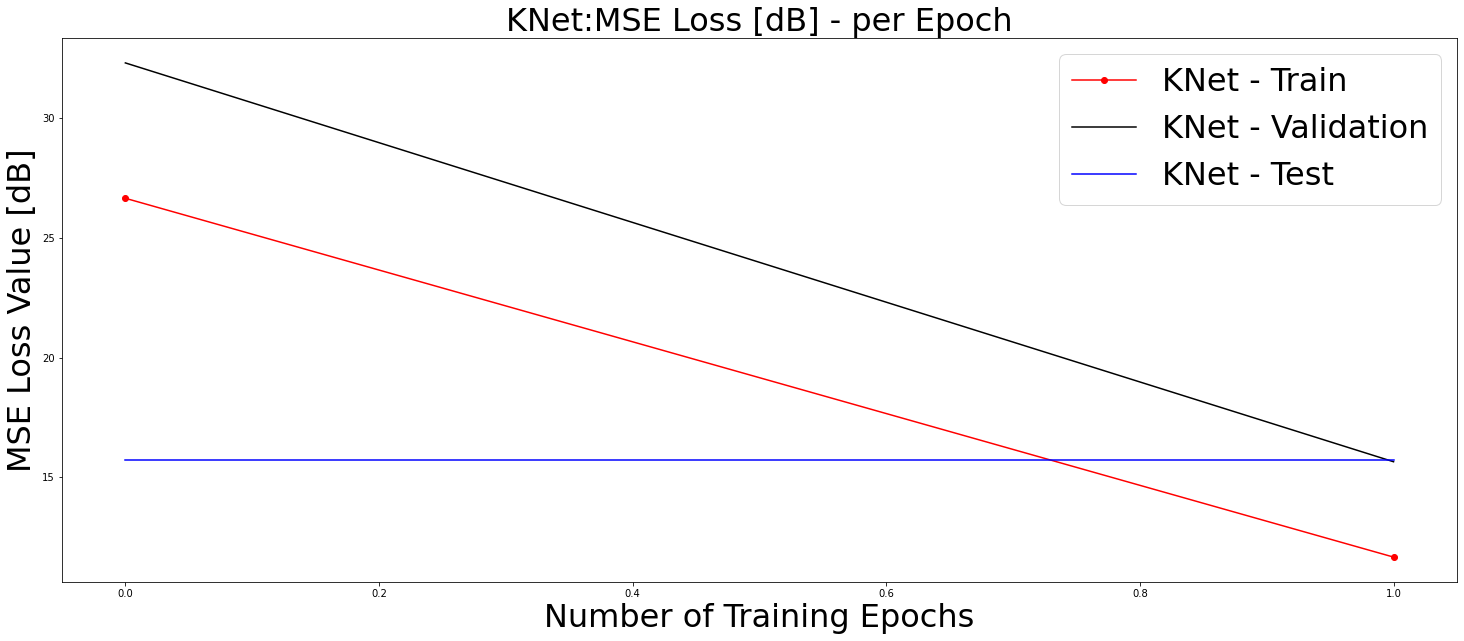

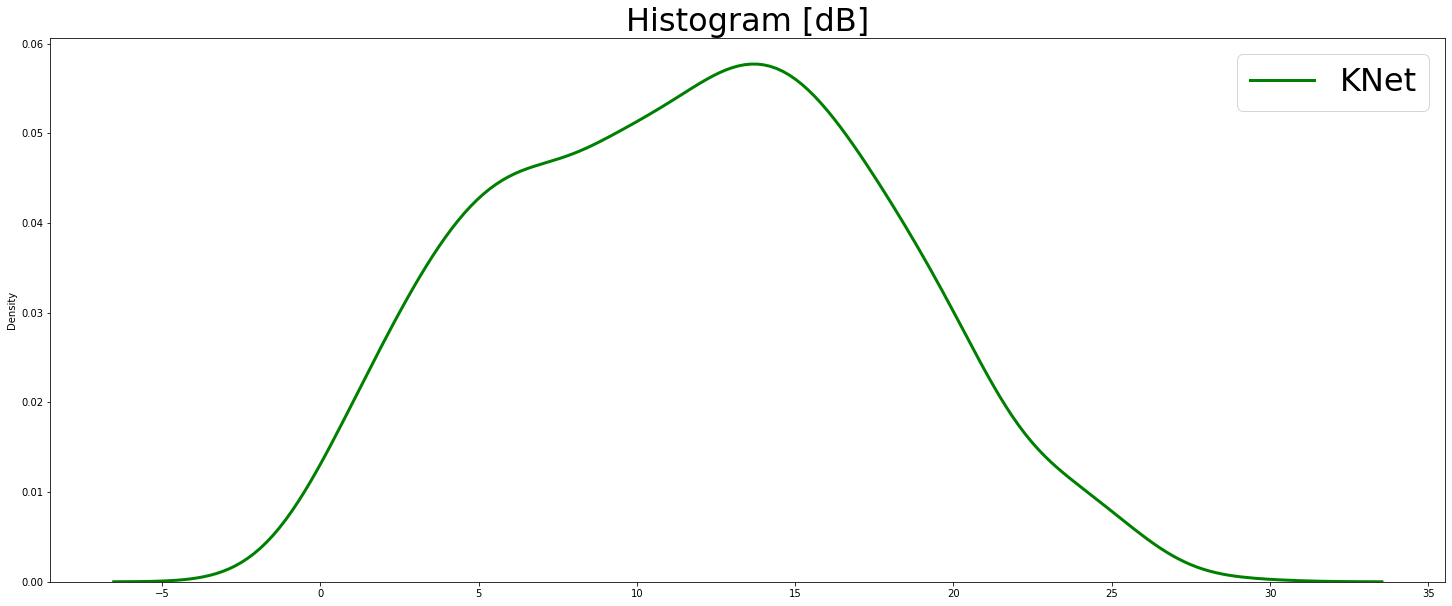

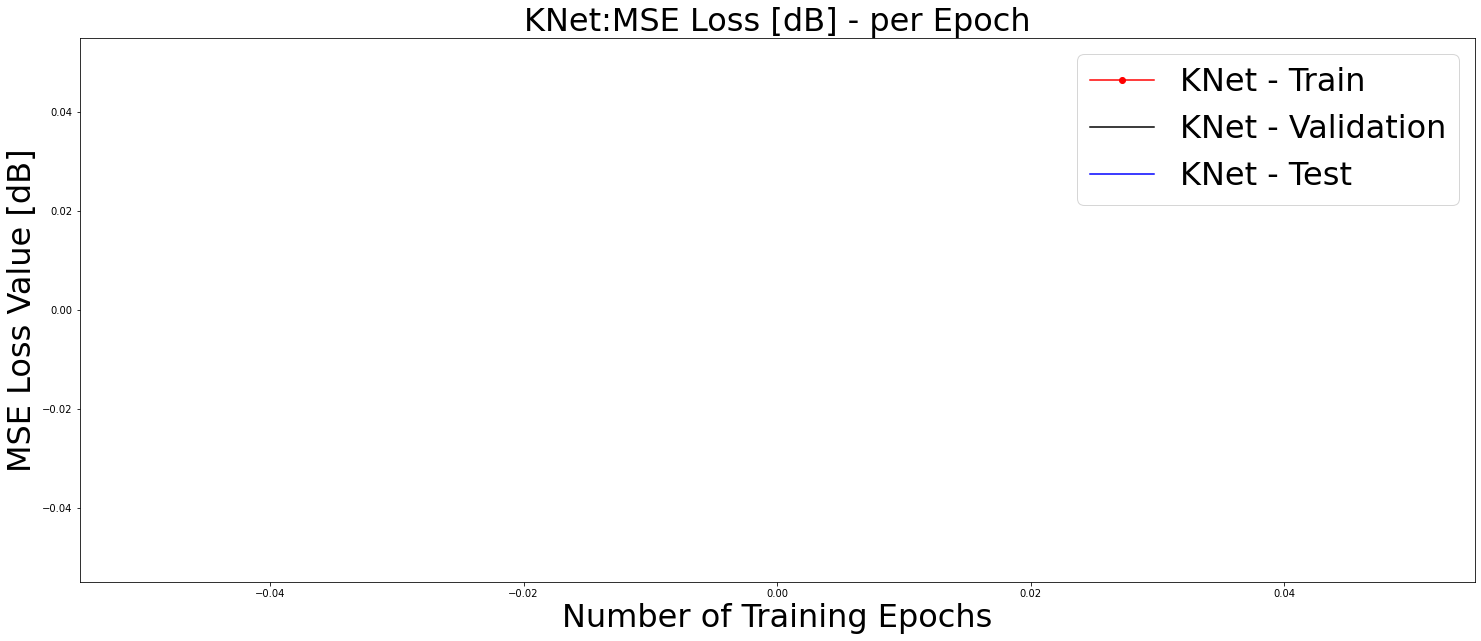

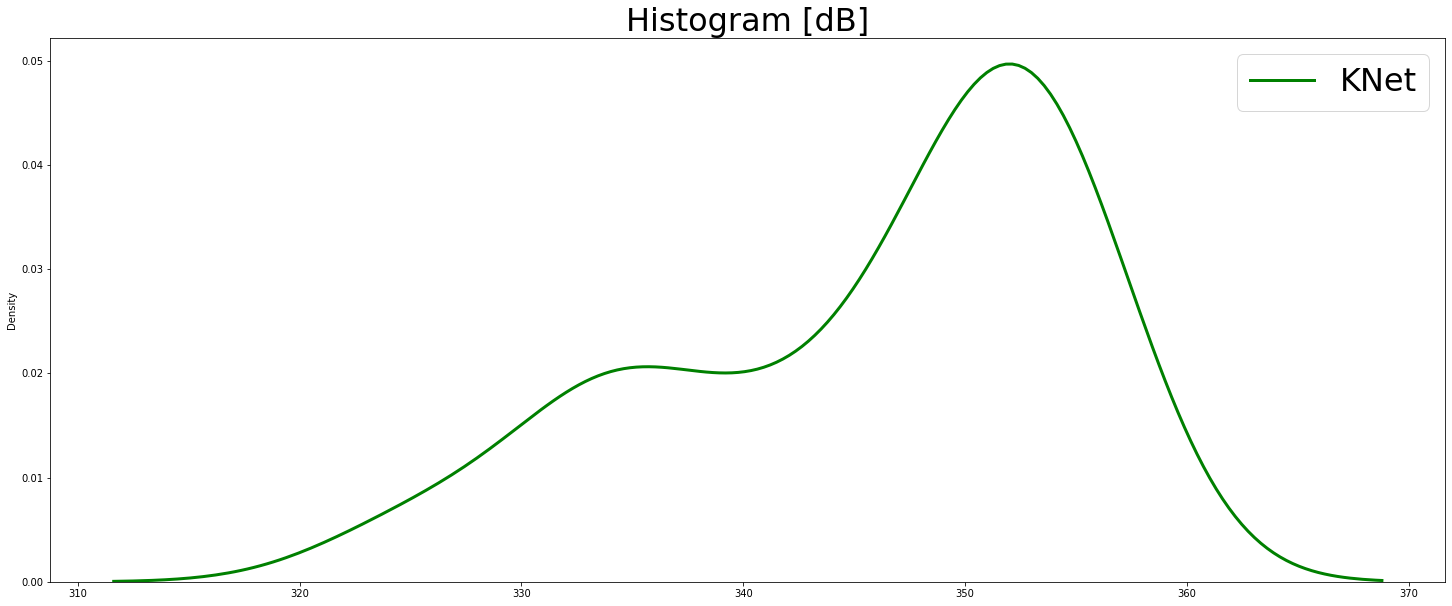

In [ ]:
###CONSTANT NU EXPERIMENT###

m = 2
n = 1
h = h_partial
T = 400
T_test = 400
T_cv = 400
m1x_0 = torch.Tensor([[0.0], [0.0]]).to(dev)
m2x_0 = torch.eye(2)
EPOCHS = 200
BATCH_SIZE = 10
LR = 1e-3
WD = 1e-6
warm_up_T = 100
BATCH_SIZE_warm = 2
EPOCHS_warm = 30
warm_up_T_cv = 100

#writer = SummaryWriter(log_dir=ROOT_PATH+"KalmanNet", comment=f"EPOCHS_{EPOCHS}_LR_{LR}_BSIZ_{BATCH_SIZE}_WD_{WD}")


linewidth=0.5
markersize=2
title_size=7
ax_label_size=7

vs = [0, -10, -20]
#vs= [0]
r2s = [10, 2, 1, 0.5, 0.1, 0.01, 0.001, 0.0001]
#vs = [-20]
#r2s = [0.0001]
#r2s =[2, 1, 0.5]
#r2s = [0.1]
vs = [0]
#r2s = [0.01]
for v in vs:


  q2s = list(map(lambda x: x*(10**(v/10)), r2s))
  for r2, q2 in zip(r2s, q2s):
    print(f"Beginning with q2 {q2}, r2 {r2}.")
    today = date.today()
    now = datetime.datetime.now()
    strToday = today.strftime("%m.%d.%y")
    strNow = now.strftime("%H:%M:%S")
    strTime = strToday + "_" + strNow
    print("Current Time =", strTime)


    Q_true = q2 * torch.eye(m)
    R_true = r2 * torch.eye(n)

    
    


    q = np.sqrt(q2)
    r = np.sqrt(r2)
    input_ = np.load(ROOT_PATH+f"Datasets/Pendulum/decimated_noisy_data/pendulum_decimated_noisy_q2_{q2:.0e}_r2_{r2:.0e}_v{v}.npz")
    target_ = np.load(ROOT_PATH+f"Datasets/Pendulum/decimated_clean_data/pendulum_decimated_q2_{q2:.0e}_v_{v}.npz")
    train_input = torch.from_numpy(input_["training_set"][:1000, 0:1, :]).float().to(dev)
    train_target = torch.from_numpy(target_["training_set"][:1000, :, :]).float().to(dev)
    cv_input = torch.from_numpy(input_["validation_set"][:200, 0:1, :]).float().to(dev)
    cv_target = torch.from_numpy(target_["validation_set"][:200, ...]).float().to(dev)
    
    train_input_warm = torch.from_numpy(input_["training_set"][2000:2500, 0:1, :warm_up_T]).float().to(dev)
    train_target_warm = torch.from_numpy(target_["training_set"][2000:2500, :, :warm_up_T]).float().to(dev)
    cv_input_warm_up = torch.from_numpy(input_["validation_set"][500:550, 0:1, :warm_up_T_cv]).float().to(dev)
    cv_target_warm_up = torch.from_numpy(target_["validation_set"][500:550, :, :warm_up_T_cv]).float().to(dev)

    test_input = torch.from_numpy(input_["test_set"][:, 0:1, :]).float().to(dev)
    test_target = torch.from_numpy(target_["test_set"][:, :, :]).float().to(dev)
    print(train_input.shape, train_target.shape, cv_input.shape, cv_target.shape)


    #WARM UP PHASE
    print("WARM UP PHASE")
    sys_model = SystemModel(f, Q_true, h, R_true, warm_up_T, T_test, warm_up_T_cv)
    #sys_model.InitSequence(m1x_0, m2x_0)


    modelFolder = ROOT_PATH +f"Simulations_results/Pendulum/KalmanNet/partial_observation_lr_{LR}_WD_{WD}_BS_{BATCH_SIZE}_r2_{r2}_v_{v}/models_{q2:.0e}_r2_{r2:.0e}_v_{v}"
    folder = ROOT_PATH + f"Simulations_results/Pendulum/KalmanNet/partial_observation_lr_{LR}_WD_{WD}_BS_{BATCH_SIZE}_r2_{r2}_v_{v}"
    os.makedirs(modelFolder+"/", exist_ok=True)
    KNet_Pipeline = Pipeline_EKF(strTime, modelFolder, f"KNet")
    KNet_Pipeline.setssModel(sys_model)
    KNet_model = KalmanNetNN()
    KNet_model.Build(sys_model)
    KNet_Pipeline.setModel(KNet_model)
    KNet_Pipeline.setTrainingParams(n_Epochs=EPOCHS_warm, n_Batch=BATCH_SIZE_warm, learningRate=LR, weightDecay=WD)
    #KNet_Pipeline.NNTrain(train_input_warm, train_target_warm, cv_input_warm_up, cv_target_warm_up, save_model=False, early_stopping=False, true_init=1)
    KNet_Pipeline.NNTrain(train_input_warm, train_target_warm, cv_input_warm_up, cv_target_warm_up)
    print("ACTUAL TRAINING PHASE")
    #TRAINING PHASE
    sys_model = SystemModel(f, Q_true, h, R_true, T, T_test, T_cv)
    #sys_model.InitSequence(m1x_0, m2x_0)
    KNet_Pipeline.setssModel(sys_model)
    #KNet_model.InitSequence(sys_model.m1x_0, sys_model.T)
    #KNet_Pipeline.setModel(KNet_model)

    KNet_Pipeline.setTrainingParams(n_Epochs=EPOCHS, n_Batch=BATCH_SIZE, learningRate=LR, weightDecay=WD)
    #KNet_Pipeline.NNTrain(train_input, train_target, cv_input, cv_target, save_model=True, early_stopping=False, patience_early=20, true_init=1, patience_scheduler=15, scheduler_factor=0.5, threshold=0.1)
    KNet_Pipeline.NNTrain(train_input, train_target, cv_input, cv_target)
    
    cv_loss = KNet_Pipeline.MSE_cv_linear_epoch.cpu().numpy()
    training_loss = KNet_Pipeline.MSE_train_linear_epoch.cpu().numpy()
    

    np.savez(folder + f"/training_loss_q2_{q2:.0e}_r2_{r2:.0e}_v_{v}.npz", training_loss=training_loss, validation_loss=cv_loss, batch_size=BATCH_SIZE, epochs=EPOCHS, learning_rate=LR, weight_decay= WD)

    """
    [MSE_test_linear_arr_total, MSE_test_dB_avg_total, MSE_test_dB_std_total,
    MSE_test_linear_arr_theta, MSE_test_dB_avg_theta, MSE_test_dB_std_theta,
    MSE_test_linear_arr_omega, MSE_test_dB_avg_omega, MSE_test_dB_std_omega, x_out_array] = KNet_Pipeline.NNTest(test_input, test_target, true_init=1)
    """
    [MSE_test_linear_arr_total, MSE_test_dB_avg_total, MSE_test_dB_std_total,
    MSE_test_linear_arr_theta, MSE_test_dB_avg_theta, MSE_test_dB_std_theta,
    MSE_test_linear_arr_omega, MSE_test_dB_avg_omega, MSE_test_dB_std_omega, x_out_array] = KNet_Pipeline.NNTest(test_input, test_target)
    KNet_Pipeline.PlotTrain_KF()
    KNet_Pipeline.save()
    
    np.savez(folder+f"/test_{q2:.0e}_{r2:.0e}_v{v}.npz", MSE_linear_arr_total=MSE_test_linear_arr_total.cpu(), 
            MSE_std_total=MSE_test_dB_std_total.cpu(), MSE_db_avg_total=MSE_test_dB_avg_total.cpu(),
            MSE_linear_arr_theta=MSE_test_linear_arr_theta.cpu(), MSE_std_theta=MSE_test_dB_std_theta.cpu(), 
            MSE_db_avg_theta=MSE_test_dB_avg_theta.cpu(), MSE_linear_arr_omega=MSE_test_linear_arr_omega.cpu(), 
            MSE_std_omega=MSE_test_dB_std_omega.cpu(), MSE_db_avg_omega=MSE_test_dB_avg_omega.cpu(), 
            test_out=x_out_array.cpu(), batch_size=BATCH_SIZE, epochs=EPOCHS, learning_rate=LR, weight_decay=WD)
    """

    plt.plot([i for i in range(1, len(training_loss)+1)], 10*np.log10(training_loss), 'r-', label="training_loss", linewidth=linewidth, markersize=markersize)
    plt.plot([i for i in range(1, len(cv_loss)+1)], 10*np.log10(cv_loss), 'g-', label = "validation loss", linewidth=linewidth, markersize=markersize)
    plt.axhline(MSE_test_dB_avg_total, color='r', label="test loss", linewidth=linewidth)
    plt.xlabel("EPOCHS")
    plt.ylabel("MSE")
    plt.title(f"Training-Validation loss q^2: {q2}, r^2: {r2}, $\nu$: {v} dB ")
    plt.legend()
    plt.tight_layout()
    plt.savefig(folder + f"/loss_plot_q2_{q2:.0e}_r2_{r2:.0e}_v_{v}.png")
    plt.close()
  
    del KNet_Pipeline
    del KNet_model
    """  


Evaluation for r2 10, q2 1.0 

Beginning with q2 1.0, r2 10.
Current Time = 06.10.22_13:19:58
WARM UP PHASE
0, MSE Training total/theta/omega: 67.52/69.64/63.23 [dB], MSE Validation total/theta/omega :63.84/65.96/59.52 [dB]
Optimal idx: 0 Optimal : tensor(63.8377) [dB]
1, MSE Training total/theta/omega: 66.89/69.04/62.42 [dB], MSE Validation total/theta/omega :62.27/64.41/57.84 [dB]
Optimal idx: 1 Optimal : tensor(62.2654) [dB]
ACTUAL TRAINING PHASE
0, MSE Training total/theta/omega: 60.34/62.46/56.05 [dB], MSE Validation total/theta/omega :60.00/62.17/55.48 [dB]
Optimal idx: 0 Optimal : tensor(60.0039) [dB]
1, MSE Training total/theta/omega: 47.17/49.40/42.34 [dB], MSE Validation total/theta/omega :58.65/60.85/54.01 [dB]
Optimal idx: 1 Optimal : tensor(58.6540) [dB]
KNet-MSE Test: tensor(58.3866) [dB]
KNet- STD Test: tensor(5.2523) [dB]
Inference Time: 45.927889585494995


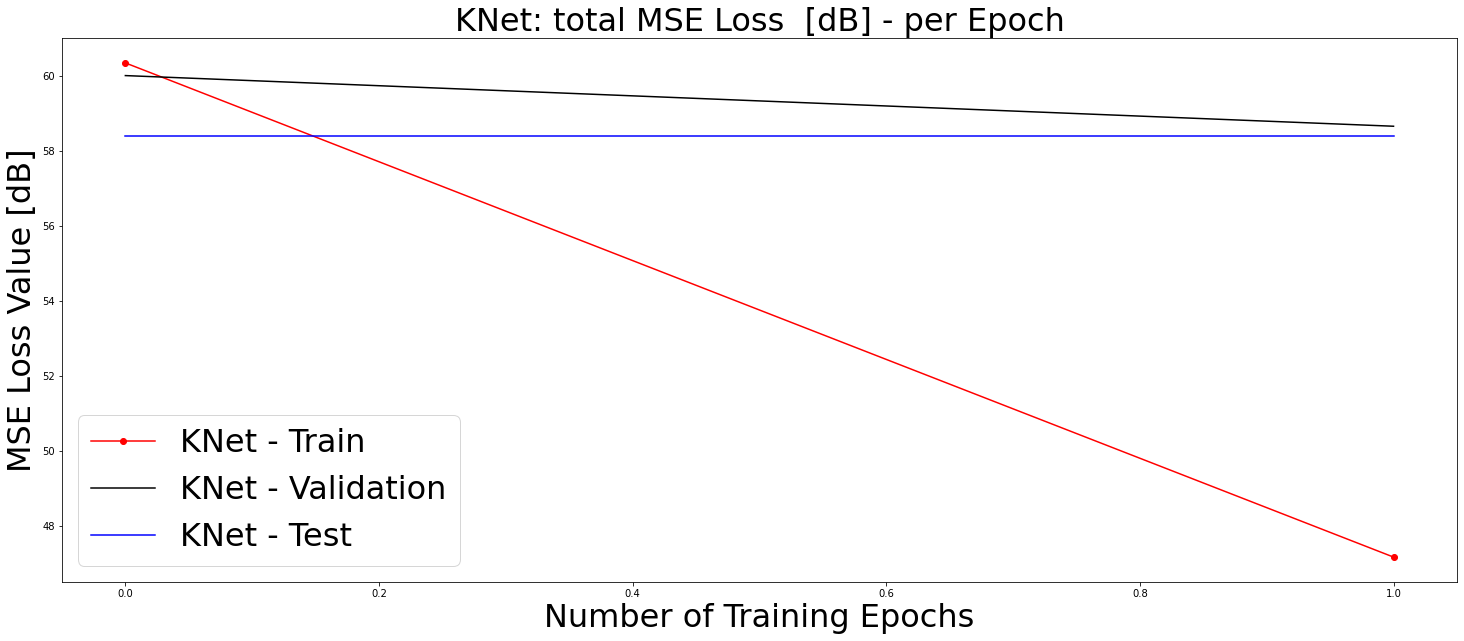

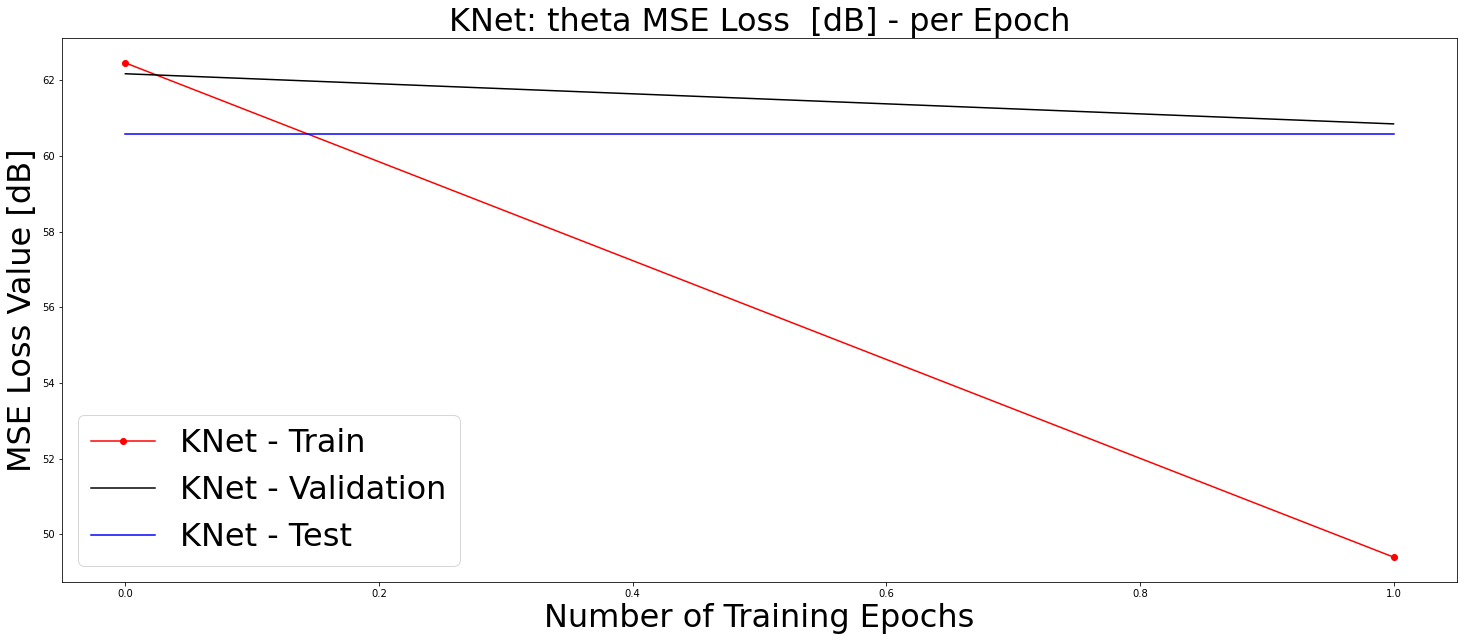

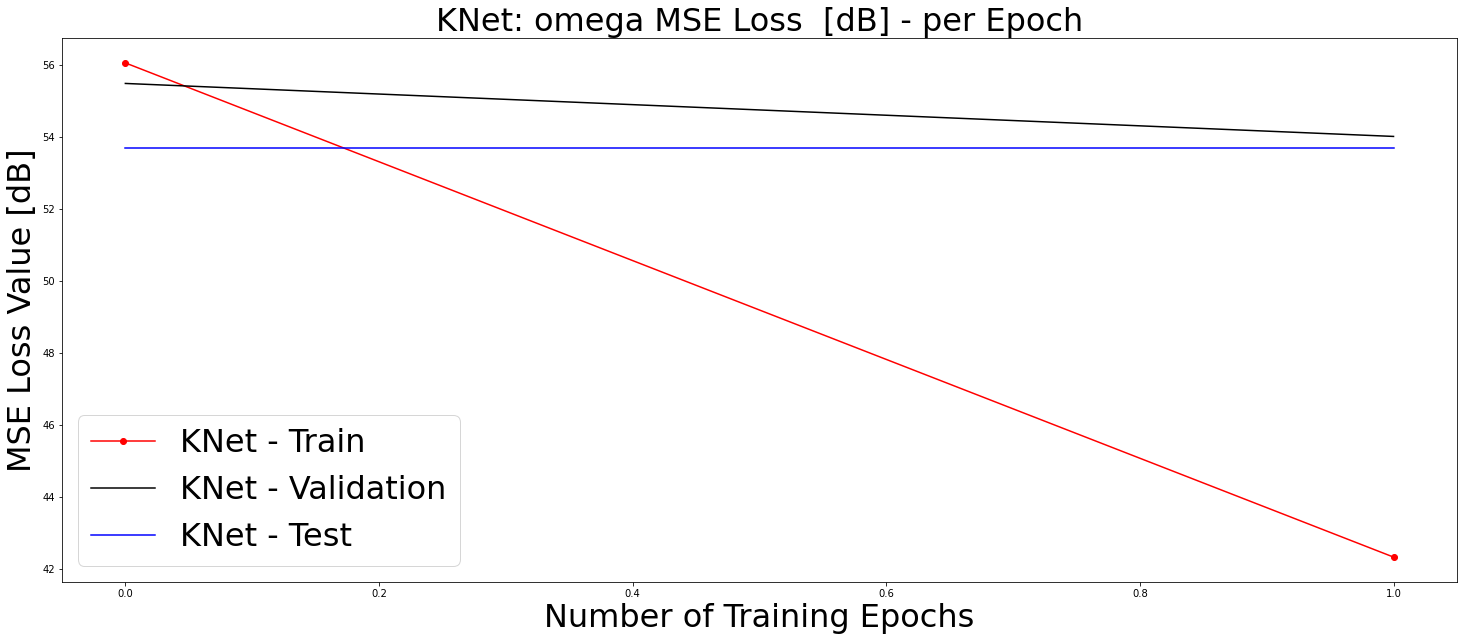

In [ ]:
###CONSTANT Q2 EXPERIMENT###

m = 2
n = 1
h = h_partial
T = 50
T_test = 50
T_cv = 50
m1x_0 = torch.Tensor([[0.0], [0.0]]).to(dev)
m2x_0 = torch.eye(2)
EPOCHS = 2
BATCH_SIZE = 10
LR = 1e-4
WD = 1e-7
warm_up_T = 50
BATCH_SIZE_warm = 2
EPOCHS_warm = 2
warm_up_T_cv = 50
modelKnow = "partial"
#writer = SummaryWriter(log_dir=ROOT_PATH+"KalmanNet", comment=f"EPOCHS_{EPOCHS}_LR_{LR}_BSIZ_{BATCH_SIZE}_WD_{WD}")


linewidth=0.5
markersize=2
title_size=7
ax_label_size=7




r2s = [10, 2, 1, 0.5, 0.1, 0.01, 0.001, 0.0001]
r2s = [0.5, 0.1, 0.01, 0.001, 0.0001]
r2s = [10]
q2s = [0, -10, -20]
q2s = [0]
q2s = list(map(lambda x: 10**(x/10), q2s))
v = 0

for q2 in q2s:
  input_ = np.load(ROOT_PATH+f"Datasets/Pendulum/decimated_clean_data/pendulum_decimated_q2_{q2:.0e}_v_{v}.npz")
  target_ = input_
  for r2 in r2s:
    print(f"Evaluation for r2 {r2}, q2 {q2} \n")
    
    r = np.sqrt(r2)
    q = np.sqrt(q2)

    """
    if modelKnow == "full":
      input_test = torch.from_numpy(input_["test_set"][:, :, :]) + torch.randn(input_["test_set"][:, :, :].shape) * r
      target_test = torch.from_numpy(target_test_).float().to(dev)

      input_val = torch.from_numpy(input_["validation_set"][:200, :, :]) + torch.randn(input_["validation_set"][:200, :, :].shape) * r
      target_val = torch.from_numpy(target_val_).float().to(dev)
      h = h_full
      NL_m = 2  # DIMENSION OF STATE
      NL_n = 2

    if modelKnow == "nonlinear":
      input_test = input_["test_set"]
      target_test = torch.from_numpy(target_test_).float().to(dev)

      input_test = input_test[:, 0:1, :]
      input_test = np.sin(input_test) + np.random.randn(*input_test.shape) * r
      input_test = torch.from_numpy(input_test).float().to(dev)

      input_val = input_["validation_set"][:200, 0:1, ...]
      target_val = torch.from_numpy(target_val_).float().to(dev)

      input_val = np.sin(input_val) + np.random.randn(*input_val.shape) * r
      input_val = torch.from_numpy(input_val).float().to(dev)
      h = h_nonlinear
      NL_m = 2  # DIMENSION OF STATE
      NL_n = 1
    """

    if modelKnow == "partial":
      train_input = torch.from_numpy(input_["training_set"][:200, 0:1, :50]).to(dev) + torch.randn(input_["training_set"][:200, 0:1, :50].shape) * r
      train_target = torch.from_numpy(target_["training_set"][:200, :, :50]).float().to(dev)
      cv_input = torch.from_numpy(input_["validation_set"][:200, 0:1, :50]).to(dev) + torch.randn(input_["validation_set"][:200, 0:1, :50].shape) * r
      cv_target = torch.from_numpy(target_["validation_set"][:200, :, :50]).float().to(dev)
       
      train_input_warm_up = torch.from_numpy(input_["training_set"][2000:2200, 0:1, :warm_up_T]).to(dev) + torch.randn(input_["training_set"][2000:2200, 0:1, :warm_up_T].shape) * r
      train_target_warm_up = torch.from_numpy(target_["training_set"][2000:2200, :, :warm_up_T]).float().to(dev)
      cv_input_warm_up = torch.from_numpy(input_["validation_set"][500:550, 0:1, :warm_up_T_cv]).to(dev) + torch.randn(input_["validation_set"][500:550, 0:1, :warm_up_T_cv].shape) * r
      cv_target_warm_up = torch.from_numpy(target_["validation_set"][500:550, :, :warm_up_T_cv]).float().to(dev)

      test_input = torch.from_numpy(input_["test_set"][:, 0:1, :50]).to(dev) + torch.randn(input_["test_set"][:, 0:1, :50].shape) * r
      test_target = torch.from_numpy(target_["test_set"][:, :, :50]).float().to(dev)

      h = h_partial
      m = 2  # DIMENSION OF STATE
      n = 1

    train_input = train_input.float().to(dev)
    cv_input = cv_input.float().to(dev)
    train_input_warm_up = train_input_warm_up.float().to(dev)
    cv_input_warm_up = cv_input_warm_up.float().to(dev)
    test_input = test_input.float().to(dev)
    cv_input = cv_input.float().to(dev)


  
    print(f"Beginning with q2 {q2}, r2 {r2}.")
    today = date.today()
    now = datetime.datetime.now()
    strToday = today.strftime("%m.%d.%y")
    strNow = now.strftime("%H:%M:%S")
    strTime = strToday + "_" + strNow
    print("Current Time =", strTime)


    Q_true = q2 * torch.eye(m)
    R_true = r2 * torch.eye(n)

    #WARM UP PHASE
    print("WARM UP PHASE")
    sys_model = SystemModel(f, Q_true, h, R_true, warm_up_T, T_test, warm_up_T_cv)
    #sys_model.InitSequence(m1x_0, m2x_0)


    modelFolder = ROOT_PATH +f"Simulations_results/Pendulum/KalmanNet/constant_q2_experiment/experiment_{q2:.0e}_r2_{r2:.0e}_v_{v}_small/models"
    folder = ROOT_PATH + f"Simulations_results/Pendulum/KalmanNet/constant_q2_experiment/experiment_{q2:.0e}_r2_{r2:.0e}_v_{v}_small/losses"
    os.makedirs(modelFolder+"/", exist_ok=True)
    os.makedirs(folder+"/", exist_ok=True)
    KNet_Pipeline = Pipeline_EKF(strTime, modelFolder, f"KNet")
    KNet_Pipeline.setssModel(sys_model)
    KNet_model = KalmanNetNN()
    KNet_model.Build(sys_model)
    KNet_Pipeline.setModel(KNet_model)
    KNet_Pipeline.setTrainingParams(n_Epochs=EPOCHS_warm, n_Batch=BATCH_SIZE_warm, learningRate=LR, weightDecay=WD)
    #KNet_Pipeline.NNTrain(train_input_warm, train_target_warm, cv_input_warm_up, cv_target_warm_up, save_model=False, early_stopping=False, true_init=1)
    KNet_Pipeline.NNTrain(train_input_warm_up, train_target_warm_up, cv_input_warm_up, cv_target_warm_up)
    print("ACTUAL TRAINING PHASE")
    #TRAINING PHASE
    sys_model = SystemModel(f, Q_true, h, R_true, T, T_test, T_cv)
    #sys_model.InitSequence(m1x_0, m2x_0)
    KNet_Pipeline.setssModel(sys_model)
    #KNet_model.InitSequence(sys_model.m1x_0, sys_model.T)
    #KNet_Pipeline.setModel(KNet_model)

    KNet_Pipeline.setTrainingParams(n_Epochs=EPOCHS, n_Batch=BATCH_SIZE, learningRate=LR, weightDecay=WD)
    #KNet_Pipeline.NNTrain(train_input, train_target, cv_input, cv_target, save_model=True, early_stopping=False, patience_early=20, true_init=1, patience_scheduler=15, scheduler_factor=0.5, threshold=0.1)
    KNet_Pipeline.NNTrain(train_input, train_target, cv_input, cv_target)
    
    cv_loss = KNet_Pipeline.MSE_cv_linear_epoch.detach().cpu().numpy()
    training_loss = KNet_Pipeline.MSE_train_linear_epoch.detach().cpu().numpy()
    

    np.savez(folder + f"/training_loss.npz", training_loss=training_loss, validation_loss=cv_loss, batch_size=BATCH_SIZE, epochs=EPOCHS, learning_rate=LR, weight_decay= WD)

    """
    [MSE_test_linear_arr_total, MSE_test_dB_avg_total, MSE_test_dB_std_total,
    MSE_test_linear_arr_theta, MSE_test_dB_avg_theta, MSE_test_dB_std_theta,
    MSE_test_linear_arr_omega, MSE_test_dB_avg_omega, MSE_test_dB_std_omega, x_out_array] = KNet_Pipeline.NNTest(test_input, test_target, true_init=1)
    """
    [MSE_test_linear_arr_total, MSE_test_dB_avg_total, MSE_test_dB_std_total,
    MSE_test_linear_arr_theta, MSE_test_dB_avg_theta, MSE_test_dB_std_theta,
    MSE_test_linear_arr_omega, MSE_test_dB_avg_omega, MSE_test_dB_std_omega, x_out_array] = KNet_Pipeline.NNTest(test_input, test_target)
    KNet_Pipeline.PlotTrain_KF()
    KNet_Pipeline.save()
    
    np.savez(folder+f"/test_loss.npz", MSE_linear_arr_total=MSE_test_linear_arr_total.cpu(), 
            MSE_std_total=MSE_test_dB_std_total.cpu(), MSE_db_avg_total=MSE_test_dB_avg_total.cpu(),
            MSE_linear_arr_theta=MSE_test_linear_arr_theta.cpu(), MSE_std_theta=MSE_test_dB_std_theta.cpu(), 
            MSE_db_avg_theta=MSE_test_dB_avg_theta.cpu(), MSE_linear_arr_omega=MSE_test_linear_arr_omega.cpu(), 
            MSE_std_omega=MSE_test_dB_std_omega.cpu(), MSE_db_avg_omega=MSE_test_dB_avg_omega.cpu(), 
            test_out=x_out_array.cpu(), batch_size=BATCH_SIZE, epochs=EPOCHS, learning_rate=LR, weight_decay=WD)
    """

    plt.plot([i for i in range(1, len(training_loss)+1)], 10*np.log10(training_loss), 'r-', label="training_loss", linewidth=linewidth, markersize=markersize)
    plt.plot([i for i in range(1, len(cv_loss)+1)], 10*np.log10(cv_loss), 'g-', label = "validation loss", linewidth=linewidth, markersize=markersize)
    plt.axhline(MSE_test_dB_avg_total, color='r', label="test loss", linewidth=linewidth)
    plt.xlabel("EPOCHS")
    plt.ylabel("MSE")
    plt.title(f"Training-Validation loss q^2: {q2}, r^2: {r2}, $\nu$: {v} dB ")
    plt.legend()
    plt.tight_layout()
    plt.savefig(folder + f"/loss_plot_q2_{q2:.0e}_r2_{r2:.0e}_v_{v}.png")
    plt.close()
  
    del KNet_Pipeline
    del KNet_model
    """  

In [ ]:
dev

device(type='cuda', index=0)

tensor([[0.0306, 0.0306],
        [0.0481, 0.0481]], grad_fn=<SqueezeBackward0>)

In [ ]:
out.shape

torch.Size([2, 2])

In [ ]:
h_full

<function model.h_full>